### Mobile Games A/B Testing - Cookie Cats

Когда игрок устанавливал игру, ему или ей случайным образом назначались контрольные группы gate_30 или gate_40.

У нас есть данные о 90 189 игроках, которые установили игру во время проведения AB-теста. 
Переменные: 
 - userid: уникальный номер, идентифицирующий каждого игрока. 
 - version: попал ли игрок в контрольную группу (gate_30 - ворота 30 уровня) или группу с перенесенными воротами (gate_40 - ворота 40 уровня)
 - sum_gamerounds: количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки
 - retention_1: Игрок вернулся и поиграл через 1 день после установки? 
 - retention_7: Игрок вернулся и поиграл через 7 дней после установки?
 
Наша цель - изучить, что происходит, когда происходит перемещение с уровня 30 на уровень 40, используя результаты A/B-теста Cookie Cats

### Загрузка и изучение данных датасета

In [2]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt

import statistics
from scipy import stats

import numpy as np

import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

from matplotlib.ticker import FuncFormatter

In [3]:
# Загружаем файл с данными
df = pd.read_csv("cookie_cats.csv")

In [4]:
# Изучаем основную информацию о наборе данных

def df_info(df, head=5):
    print("---------- INFO ----------", "\n")
    print(df.info(), "\n")
    print("---------- SHAPE ----------", "\n")
    print(df.shape, "\n")
    print("---------- DATA TYPES ----------", "\n")
    print(df.dtypes, "\n")
    print("---------- DATA HEAD ----------", "\n")
    print(df.head(head), "\n")
    print("---------- DATA TAIL ----------", "\n")
    print(df.tail(head), "\n")
    print("---------- NULL VALUES ----------", "\n")
    print(df.isnull().sum(), "\n")
    print("---------- STATISTICS ----------", "\n")
    print(df.describe().T)

df_info(df)

---------- INFO ---------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None 

---------- SHAPE ---------- 

(90189, 5) 

---------- DATA TYPES ---------- 

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object 

---------- DATA HEAD ---------- 

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True      

In [5]:
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


In [6]:
df.groupby("version")[["sum_gamerounds"]].nunique()

,sum_gamerounds
version,
gate_30,779
gate_40,792


Количество игровых раундов незначительно больше для «gate30»

Проверяем данные по количеству сыгранных раундов на наличие вбросов:

In [8]:
df.nlargest(10, ['sum_gamerounds'])

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True
46344,5133952,gate_30,2251,True,True
87007,9640085,gate_30,2156,True,True
36933,4090246,gate_40,2124,True,True
88328,9791599,gate_40,2063,True,True
6536,725080,gate_40,2015,True,True


Убираем вброс из данных - маловероятно, что одним игроком было сыграно 49854 раундов.

In [9]:
df = df[df.sum_gamerounds < 3000]

Проверяем:

In [11]:
df.nlargest(10, ['sum_gamerounds'])

,userid,version,sum_gamerounds,retention_1,retention_7
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True
46344,5133952,gate_30,2251,True,True
87007,9640085,gate_30,2156,True,True
36933,4090246,gate_40,2124,True,True
88328,9791599,gate_40,2063,True,True
6536,725080,gate_40,2015,True,True
655,69927,gate_30,1906,True,True


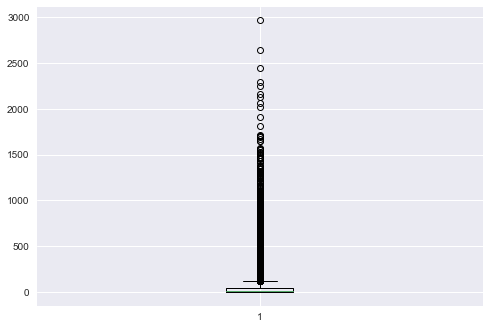

In [12]:
plt.boxplot(df["sum_gamerounds"]);

Удилили вброс из данных.

## A/B-тест

Чтобы применить A/B-тестирование к данных, нам необходимо выполнить основные шаги:

1. Гипотеза
2. Контроль предположений
3. Применение гипотезы¶

## Гипотезы 

Нам нужно сформулировать:
- H0: нулевую гипотезу;
- H1: альтернативную гипотезу.

- H0: она утверждает, что нет никакой разницы между контрольной и экспериментальной группами, что означает:

   - Показатели удержания одинаковы в обеих группах.
   - Нет статистически значимого результата.

- H1:существует разница между контрольной и экспериментальной группами, что означает:

   - Показатели удержания различаются в обеих группах. 
   - Это дает статистически значимый результат

Гипотеза, которую мы хотим проверить, заключается в том, является ли H1 «вероятно» верной. Итак, есть два возможных результата:
    
 - Отклонить H0 и принять H1 при наличии достаточных доказательств в выборке в пользу атиернативной гипотезы H1.
 - Не отклонять H0 из-за недостаточности доказательств в поддержку H1.

In [14]:
avr = df['sum_gamerounds'].mean()
median = df['sum_gamerounds'].median()
mode = df['sum_gamerounds'].mode()
std = df['sum_gamerounds'].std()

In [15]:
median

16.0

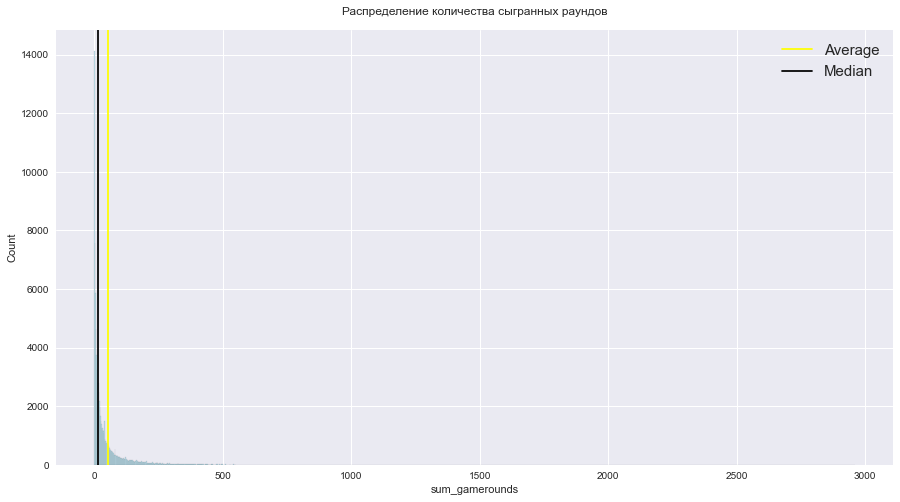

In [16]:
plt.figure(figsize = (15,8))
sns.histplot(df.sum_gamerounds, bins='auto', color = 'lightblue')
plt.title('Распределение количества сыгранных раундов', pad = 15)
plt.axvline(x = avr, ymin = 0, ymax = df['sum_gamerounds'].max(), color = 'Yellow', label = 'Average')
plt.axvline(x = median, ymin = 0, ymax = df['sum_gamerounds'].max(), color = 'black', label = 'Median')
plt.legend(fontsize=15);
plt.legend(fontsize=15, loc='upper right');

Распределение скошено влево, большинство игроков сыграли меньшее количество раундов (не более 20) в сравнении с наиболее активными игроками, кто отыграл более 200 раундов.

Построим гистограммный график активности пользователей на разных уровнях в двух исследуемых группах.

In [20]:
plt.style.use('ggplot')

g30 = df[df.version == 'gate_30']
print(Group_A.head())

g40 = df[df.version == 'gate_40']
print(Group_B.head())

bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
plot_g30 = pd.DataFrame(g30.groupby(pd.cut(Group_A['sum_gamerounds'],
                                              bins=bins)).count())
plot_g40 = pd.DataFrame(g40.groupby(pd.cut(Group_B['sum_gamerounds'],
                                              bins=bins)).count())

    userid  version  sum_gamerounds  retention_1  retention_7
0      116  gate_30               3        False        False
1      337  gate_30              38         True        False
6     1066  gate_30               0        False        False
11    2101  gate_30               0        False        False
13    2179  gate_30              39         True        False
   userid  version  sum_gamerounds  retention_1  retention_7
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
5     540  gate_40             187         True         True
7    1444  gate_40               2        False        False


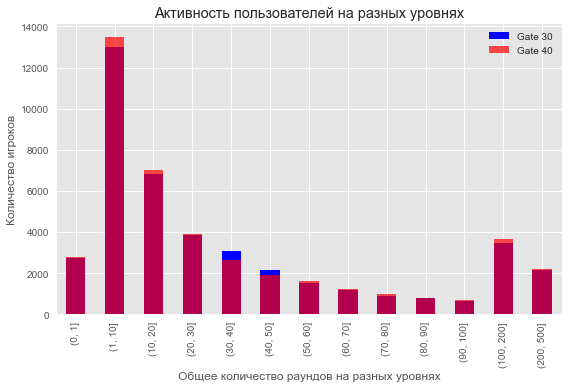

In [22]:
ax = plot_g30.plot(kind = 'bar', y='userid', color = 'blue', alpha = 1,
                  title = 'Активность пользователей на разных уровнях')
plot_g40.plot(kind = 'bar', y = 'userid', ax = ax, color = 'red', alpha = 0.7)
ax.set_xlabel('Общее количество раундов на разных уровнях')
ax.set_ylabel('Количество игроков')
plt.legend(['Gate 30', 'Gate 40'])
plt.tight_layout()
plt.grid(True)

Гафик показывает, что между двумя группами нет большой разницы.
Небольшие отличия есть в пределах 30 - 40 сыгранных раундов и 1 - 10 сыгранных руандов.

Воспользуемся Bootstrapp для более детального иследования:

In [24]:
boot_1d = []
for i in range(500):
  boot_mean = df.retention_1.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)
print(boot_1d)

version       gate_30   gate_40
retention_1  0.448624  0.439695
retention_1  0.448876  0.442172
retention_1  0.447204  0.444934
retention_1  0.448946  0.447017
retention_1  0.454911  0.440447
...               ...       ...
retention_1  0.449752  0.442138
retention_1  0.449565  0.445620
retention_1  0.449821  0.442682
retention_1  0.445368  0.443148
retention_1  0.448692  0.444256

[500 rows x 2 columns]


Text(0.5, 0, 'The average of 1-day retention')

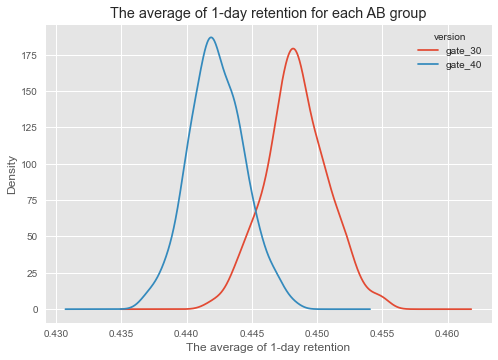

In [25]:
ax = boot_1d.plot.kde()
ax.set_title('The average of 1-day retention for each AB group')
ax.set_xlabel('The average of 1-day retention')

In [26]:
boot_2d = []
for i in range(500):
  boot_mean = df.retention_7.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_2d.append(boot_mean)

boot_2d = pd.DataFrame(boot_2d)
print(boot_2d)

version       gate_30   gate_40
retention_7  0.190363  0.182252
retention_7  0.192599  0.184843
retention_7  0.189463  0.183673
retention_7  0.190547  0.183037
retention_7  0.192293  0.183494
...               ...       ...
retention_7  0.190908  0.181613
retention_7  0.194750  0.179892
retention_7  0.189395  0.178291
retention_7  0.193526  0.180315
retention_7  0.186327  0.182189

[500 rows x 2 columns]


Text(0.5, 0, 'The average of 7-day retention')

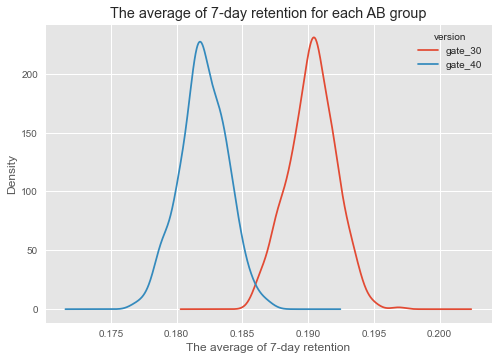

In [27]:
ax = boot_2d.plot.kde()
ax.set_title('The average of 7-day retention for each AB group')
ax.set_xlabel('The average of 7-day retention')

Просто взглянув на графики, мы видим, что, похоже, есть некоторые доказательства разницы в удержании между группами на 1 и 7 день, хотя и небольшие.

Расчет разницы в коэффициенте удержания между двумя группами A/B
Вычисление вероятности того, что 1-дневное и 7-дневное удержание выше, когда ворота находятся на уровне 30.
Оценка результатов и выдача рекомендаций

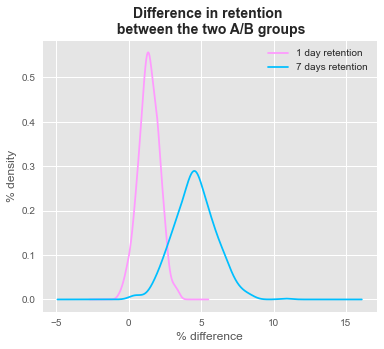

In [28]:
# Добавление столбца с процентной разницей между двумя группами A/B
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_2d['diff'] = ((boot_2d['gate_30'] - boot_2d['gate_40']) / boot_2d['gate_40'] * 100)

# Построение графика
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_2d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

In [29]:
# Вычисление вероятности того, что 1-дневное удержание будет больше, если ворота gate 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Вычисление вероятности того, что 7-дневное удержание будет больше, если ворота gate 30
prob_7 = (boot_2d['diff']>0).sum()/len(boot_2d['diff'])


print(f"Вероятность того, что 1-дневное удержание выше, когда ворота находятся на уровне 30: {round(prob_1,2)*100}% \
      \nВероятность того, что 7-дневное удержание выше, когда ворота находятся на уровне 30: {(prob_7)*100}% ")

Вероятность того, что 1-дневное удержание выше, когда ворота находятся на уровне 30: 96.0%       
Вероятность того, что 7-дневное удержание выше, когда ворота находятся на уровне 30: 100.0% 


## Вывод

Результат говорит нам о том, что существуют доказательства с вероятностью 96% и 100% того, что удержание в первый и седьмой день выше, когда ворота находятся на уровне 30, чем когда он находится на уровне 40.

Вывод таков: если мы хотим поддерживать высокий уровень удержания — как 1-дневный, так и 7-дневный — нам не следует перемещать порог с уровня 30 на уровень 40. Конечно, есть и другие показатели, на которые мы могли бы обратить внимание, например количество сыгранных игровых раундов или количество внутриигровых покупок, совершенных двумя AB-группами. Но удержание — один из наиболее важных показателей.